## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:
6/11/2019 Made Time-Cross Validation be non-overlapping

## Confusion Table Function

In [365]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [366]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [367]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [368]:
#!pip3 install -U scikit-learn scipy matplotlib

In [369]:
import pandas as pd
from sklearn import svm
import numpy as np

In [389]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 422)

In [390]:
#train_pd[5902:7100] # Google Trends part

In [391]:
train_pd = train_pd #[5902:7100]

train = np.array(train_pd)
train.shape

(7120, 422)

In [392]:
train = train[:, :149] # drop google columns

In [393]:
train = train[2:,1:] # drop date
train

array([[1, 173.199997, 8.13, ..., 395.35, 398.0, 403.7],
       [1, 172.779999, 8.16, ..., 398.0, 403.7, 383.5],
       [1, 171.169998, 8.25, ..., 403.7, 383.5, 380.0],
       ...,
       [4, 1697.430054, 2.512, ..., 1296.15, 1286.75, 1283.75],
       [4, 1706.280029, 2.501, ..., 1286.75, 1283.75, 1276.1],
       [4, 1707.6700440000002, 2.519, ..., 1283.75, 1276.1, 1276.5]],
      dtype=object)

## 2. Time-Series Cross validation

In [394]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    revised_valDataPartition = []
    
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        valset = valDataPartition[i] # Do the same for validation set
        
        print(trainset.shape[0], valset.shape[0])
        records = trainset[:,0] # record of labels for training set
        records_val = valset[:, 0] # record of labels for validation set
        #print(sum(records == 1), sum(records == 0))
        #print(sum(records_val == 1), sum(records_val == 0))
        
        ############ FOR TRAINING SET ################
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
            
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))
        
        ############## FOR VALIDATION SET ################
        if sum(records_val == 1) == 0 or sum(records_val == 0) == 0:
            revised_valDataPartition.append(np.nan)
        elif sum(records_val == 1) > sum(records_val == 0):
            while sum(records_val == 1) >= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                #print(r)
                if records_val[r] == 1:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)
            revised_valDataPartition.append(valset)
        else:
            while sum(records_val == 1) <= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                if records_val[r] == 0:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)

            revised_valDataPartition.append(valset)

    group = len(revised_trainDataPartition)
    group_val = len(revised_valDataPartition)
    print('Number of groups:', group, group_val)
    
    return revised_trainDataPartition, revised_valDataPartition, group

In [395]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30)

Last set: 7000 7410
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
118 0
Number of groups: 11 11


In [396]:
t = pd.DataFrame(valDataPartition[1])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,1,320.2,6.089,0.109487,0.565784,0.0858934,320.44,6.072,0.109337,0.565834,...,152.9,100.767,385.85,389.3,388.2,388.2,389.3,389.25,387.85,385.85
1,1,320.44,6.072,0.109337,0.565834,0.0859206,319.92,6.135,0.106634,0.565864,...,152.9,100.767,389.3,388.2,388.2,389.3,389.25,387.85,385.85,386.45
2,1,319.92,6.135,0.106634,0.565864,0.0800257,321.16,6.202,0.110136,0.566538,...,152.9,100.767,388.2,388.2,389.3,389.25,387.85,385.85,386.45,386.65
3,1,321.16,6.202,0.110136,0.566538,0.084929,318.78,6.257,0.107527,0.566251,...,152.9,100.767,388.2,389.3,389.25,387.85,385.85,386.45,386.65,385.8
4,1,318.78,6.257,0.107527,0.566251,0.0793933,313.75,6.412,0.102146,0.565909,...,152.9,100.767,389.3,389.25,387.85,385.85,386.45,386.65,385.8,386.1
5,1,313.75,6.412,0.102146,0.565909,0.0671946,315.46,6.407,0.105492,0.565838,...,152.9,100.767,389.25,387.85,385.85,386.45,386.65,385.8,386.1,383.2
6,1,315.46,6.407,0.105492,0.565838,0.0732053,315.8,6.494,0.105421,0.565764,...,152.9,100.767,387.85,385.85,386.45,386.65,385.8,386.1,383.2,383.35
7,1,315.8,6.494,0.105421,0.565764,0.0715516,317.9,6.437,0.109369,0.566258,...,152.9,100.767,385.85,386.45,386.65,385.8,386.1,383.2,383.35,381.75
8,1,317.9,6.437,0.109369,0.566258,0.0794667,320.43,6.411,0.11187,0.565999,...,152.9,100.767,386.45,386.65,385.8,386.1,383.2,383.35,381.75,382.65
9,1,320.43,6.411,0.11187,0.565999,0.0843821,321.09,6.463,0.112407,0.565741,...,152.9,100.767,386.65,385.8,386.1,383.2,383.35,381.75,382.65,382.75


In [397]:
#trainDataPartition[18]
t = pd.DataFrame(trainDataPartition[1])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0,268.45,5.27,0.171129,0.388682,0.304692,271.07,5.23,0.171098,0.387936,...,146,99.6691,366.6,365.9,365.35,365,368.85,371.6,371.55,370.65
1,0,271.07,5.23,0.171098,0.387936,0.30623,272.29,5.19,0.177139,0.38726,...,146,99.6691,365.9,365.35,365,368.85,371.6,371.55,370.65,371.5
2,0,272.29,5.19,0.177139,0.38726,0.323398,271.28,5.27,0.162345,0.385274,...,146,99.6691,365.35,365,368.85,371.6,371.55,370.65,371.5,368.5
3,0,269.28,5.27,0.15968,0.387196,0.276293,268.95,5.26,0.159062,0.389067,...,146,99.6691,368.85,371.6,371.55,370.65,371.5,368.5,368.65,369.1
4,0,268.01,5.42,0.157613,0.391404,0.264212,268.11,5.47,0.165932,0.393012,...,146,99.6691,370.65,371.5,368.5,368.65,369.1,369.1,367.95,362.5
5,0,268.11,5.47,0.165932,0.393012,0.283025,267.86,5.43,0.165403,0.395097,...,146,99.6691,371.5,368.5,368.65,369.1,369.1,367.95,362.5,363
6,0,267.86,5.43,0.165403,0.395097,0.281205,268.39,5.44,0.165842,0.39718,...,146,99.6691,368.5,368.65,369.1,369.1,367.95,362.5,363,369.1
7,0,268.39,5.44,0.165842,0.39718,0.280584,269.92,5.41,0.170818,0.398341,...,146,99.6691,368.65,369.1,369.1,367.95,362.5,363,369.1,374.4
8,0,269.92,5.41,0.170818,0.398341,0.293009,270.45,5.388,0.169692,0.399502,...,146,99.6691,369.1,369.1,367.95,362.5,363,369.1,374.4,377.9
9,0,271.21,5.56,0.162783,0.39826,0.269129,270.88,5.606,0.162164,0.399961,...,146,99.6691,362.5,363,369.1,374.4,377.9,376.35,375.5,377.15


## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [398]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [399]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
                
                # print predicitions
                pred = clf.predict(X_test)
                #print(pred)

            except:
                print('Skipped due to NaN')
                continue # nan
                
            # add up AUROCs            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [400]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 11
train: 192 339
test: 107 190
0.561366963179822
train: 194 343
test: 137 259
Skipped due to NaN
train: 192 340
test: 146 259
0.5695538853194326
train: 190 336
test: 103 182
0.5569620253164558
train: 183 323
test: 141 250
0.5283687943262412
train: 227 402
test: 114 202
0.5
train: 174 307
test: 130 259
0.6749254621347645
train: 193 342
test: 83 146
0.5634920634920635
train: 200 354
test: 132 259
0.6465938916726318
train: 190 336
test: 110 195
0.6614973262032086
Averaged Score is: 0.5848 11


0.5847511568494022

Hyperparameter Test

In [401]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))
settings_matrix = np.zeros((len(size_train_set), len(size_val_set)), dtype = 'i,i')

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift[i], size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            try:
                score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)
            except:
                print('Cannot compute score')
            settings_matrix[j][k][0] = size_train_set[j]
            settings_matrix[j][k][1] = size_val_set[k]
            
print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
print(settings_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

[0] 100 50
Last set: 7020 7120
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
98 0
Number of groups: 40 40
train: 56 100
test: 19 33
0.5
train: 48 84
test: 18 31
0.5
train: 53 94
test: 27 48
Skipped due to NaN
train: 40 71
test: 7 12
0.5
train: 24 42
test: 27 48
0.5
Skipped due to NaN
train: 35 62
test: 23 41
Skipped due to NaN
train: 42 74
test: 10 18
Skipped due to NaN
train: 53 94
test: 7 13
0.5
train: 44 77
test: 9 16
0.5
train: 16 28
test: 1 2
0.5
train: 44 78
test: 24 43
0.5625
train: 48 85
test: 25 49
0.6391666666666668
train: 21 37
test: 11 19
0.5
train: 41 72
test: 17 30
0.5158371040723981
train: 21 37
test: 10 17
0.45
train: 50 88
test: 19 33
0.48872180451127817
train: 51 100
test: 12 22
0.625
train: 55 98
test: 25 45
0.32
train: 53 100
test: 6 11
0.3333

In [402]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.5239011 , 0.55499288, 0.58475116]])

# Look for Feature Importances

In [403]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30) #10 252 100 Draft_Google_shorter 0.8795

Last set: 7000 7410
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
118 0
Number of groups: 11 11


In [404]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        print(pred)
        #print(pred)
    except:
        print('Skipped')
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 192 339
test: 107 190
[0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
0.561366963179822
train: 194 343
test: 137 259
Skipped
train: 192 340
test: 146 259
[1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Plot the accuracy through time

Standard Deviation: 0.05793635928314002
[0, 2, 3, 4, 5, 6, 7, 8, 9]


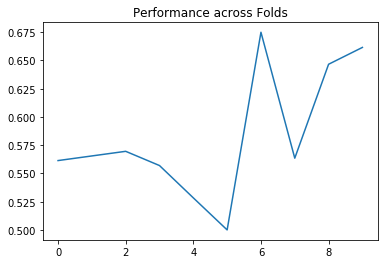

In [405]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [406]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.5]
importance = np.array([])
count = 0

for idx in range(0, len(trainDataPartition)): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

hi
0.561366963179822
0.5695538853194326
0.5569620253164558
0.5283687943262412
0.5
0.6749254621347645
0.5634920634920635
0.6465938916726318
0.6614973262032086


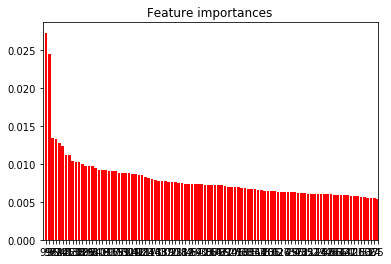

In [407]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [408]:
name = 'Combined_Sets_from_Revised.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

Top Features listed by Importance
main98 0.02725428499107658
main96 0.024504297348800465
main95 0.013397195996659653
main86 0.013288788832403375
main93 0.012700633797539914
main91 0.012284218602962242
gfp5 0.01114022336410332
main81 0.011099941884669666
main12 0.010373226879854982
invest11 0.010218468373023364
main37 0.01021266447968944
main88 0.010005801305228192
invest3 0.009757912991392344
main85 0.009737500548094117
main97 0.009711203478262051
main83 0.009457989257034923
main9 0.009234459880576746
Label_m30 0.009159645773274501
main7 0.009131481689112491
main89 0.009109974959793961
main94 0.009031516817490568
vix14 0.009004821386158483
main76 0.00883232396703659
main92 0.008816555044883994
invest8 0.008796959757960214
main90 0.008787770038828953
invest7 0.008720018151662312
gfp1 0.00859590406147718
main40 0.008569844478595124
rdi0 0.008517856611201628
invest1 0.008213772096339153
main80 0.008197580662901287
gfp6 0.008000235190603897
main72 0.007912563228953055
gfp3 0.00779763545085

['main98',
 'main96',
 'main95',
 'main86',
 'main93',
 'main91',
 'gfp5',
 'main81',
 'main12',
 'invest11',
 'main37',
 'main88',
 'invest3',
 'main85',
 'main97',
 'main83',
 'main9',
 'Label_m30',
 'main7',
 'main89',
 'main94',
 'vix14',
 'main76',
 'main92',
 'invest8',
 'main90']

# Feature Importance

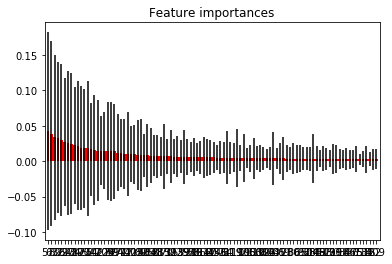

In [32]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [33]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [36]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [37]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

Top Features listed by Importance
main56 0.04246516422174906
main66 0.038890888318713866
main81 0.03352209371117746
main31 0.03316343824589267
main71 0.029538007701172927
main61 0.027638836562973338
main96 0.026174527778898057
main41 0.024717976602409993
main33 0.022179143584261544
main86 0.02192126337972254
google_hits40 0.018536965272188975
main26 0.018094151121507362
main51 0.017907962611983155
main53 0.01662669776174378
main46 0.015511696529390826
main6 0.015034778619333933
invest5 0.014968034625538185
google_hits53 0.014830217360014095
main28 0.01446104855036105
main36 0.013716114196511751
main48 0.01369902198463893
main93 0.012202968050008907
main76 0.011880261213021217
main73 0.010328238974565888
main16 0.010052793341765304
main19 0.009764406723616902
invest3 0.009464639641187931
main11 0.00859702479350911
main88 0.008526362192154482
main39 0.008260623177502284
main24 0.008066004010519183
main82 0.007844714248476117
gfp8 0.007815534136366665
main87 0.007041696130779015
google_hi

# SVM

In [376]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260) #10 252 100 Draft_Google_shorter 0.8795

Last set: 6700 7110
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 7
Number of groups: 11 11


In [377]:
test = pd.DataFrame(valDataPartition[1])

In [416]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)
    except:
        continue

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 192 339
test: 107 190
0.5106406936155837
train: 194 343
test: 137 259
train: 192 340
test: 146 259
0.5695538853194326
train: 190 336
test: 103 182
0.6136782598009094
train: 183 323
test: 141 250
0.5682217450712473
train: 227 402
test: 114 202
0.5013955342902712
train: 174 307
test: 130 259
0.5
train: 193 342
test: 83 146
0.46270797475616754
train: 200 354
test: 132 259
0.5570269625387735
train: 190 336
test: 110 195
0.5
Averaged Score is: 0.5315 11


Standard Deviation: 0.045042820127822264
[0, 2, 3, 4, 5, 6, 7, 8, 9]


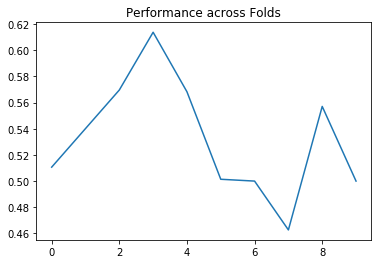

In [417]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)